In [1]:
import numpy as np
import torch

from neuraldistributions.datasets import mouse_static_loaders, extract_data_key
from neuraldistributions.models import poisson, zig, flowfa, ziffa
from neuraldistributions.trainers import base_trainer
from neuraldistributions.utility import get_loglikelihood

dataport not available, will only be able to load data locally


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from neuraldistributions.models import transforms
from neuraldistributions.datasets import static

from multiprocessing import Pool

import os
device = "cuda"

import os
from mpl_toolkits.axes_grid1 import make_axes_locatable



In [3]:
random_seed=42
dataset_dir = "../project/data"
datasets = [
    "static_edited_dsampled.zip",
]
scan_id = [2, 1]
dataset_paths = [f"{dataset_dir}/{dataset}" for dataset in datasets]
areas = [["V1", "LM"]]
neurons_ns = [1000, 907]

In [4]:
dataset_index = 0
dataset_path = dataset_paths[dataset_index]
data_key = extract_data_key(dataset_path)
area = areas[dataset_index]
neurons_n = neurons_ns[dataset_index]

dataset_config = {
    "paths": [dataset_path],
    "seed": random_seed,
    "batch_size": 4473,
    "area": area,
    "neurons_n": neurons_n,
    "normalize_images": True,
    "normalize_neurons": True,
    "return_more": True,
    "device": device,
    "shuffle_train": True,
}

dataloaders = mouse_static_loaders(**dataset_config)

100%|██████████| 5994/5994 [00:00<00:00, 289378.88it/s]


In [5]:
index_name_of_dataloader = next(iter(dataloaders["train"]))
indexes = np.arange(len(dataloaders["image_ids"][index_name_of_dataloader]["test"]))
u, inv = (np.unique(dataloaders["image_ids"][index_name_of_dataloader]["test"], return_inverse=True))
randoms = np.random.choice(np.unique(inv), size=5)

In [6]:
batch = (next(iter(dataloaders["test"][index_name_of_dataloader])))
inputs, targets = batch[:2]

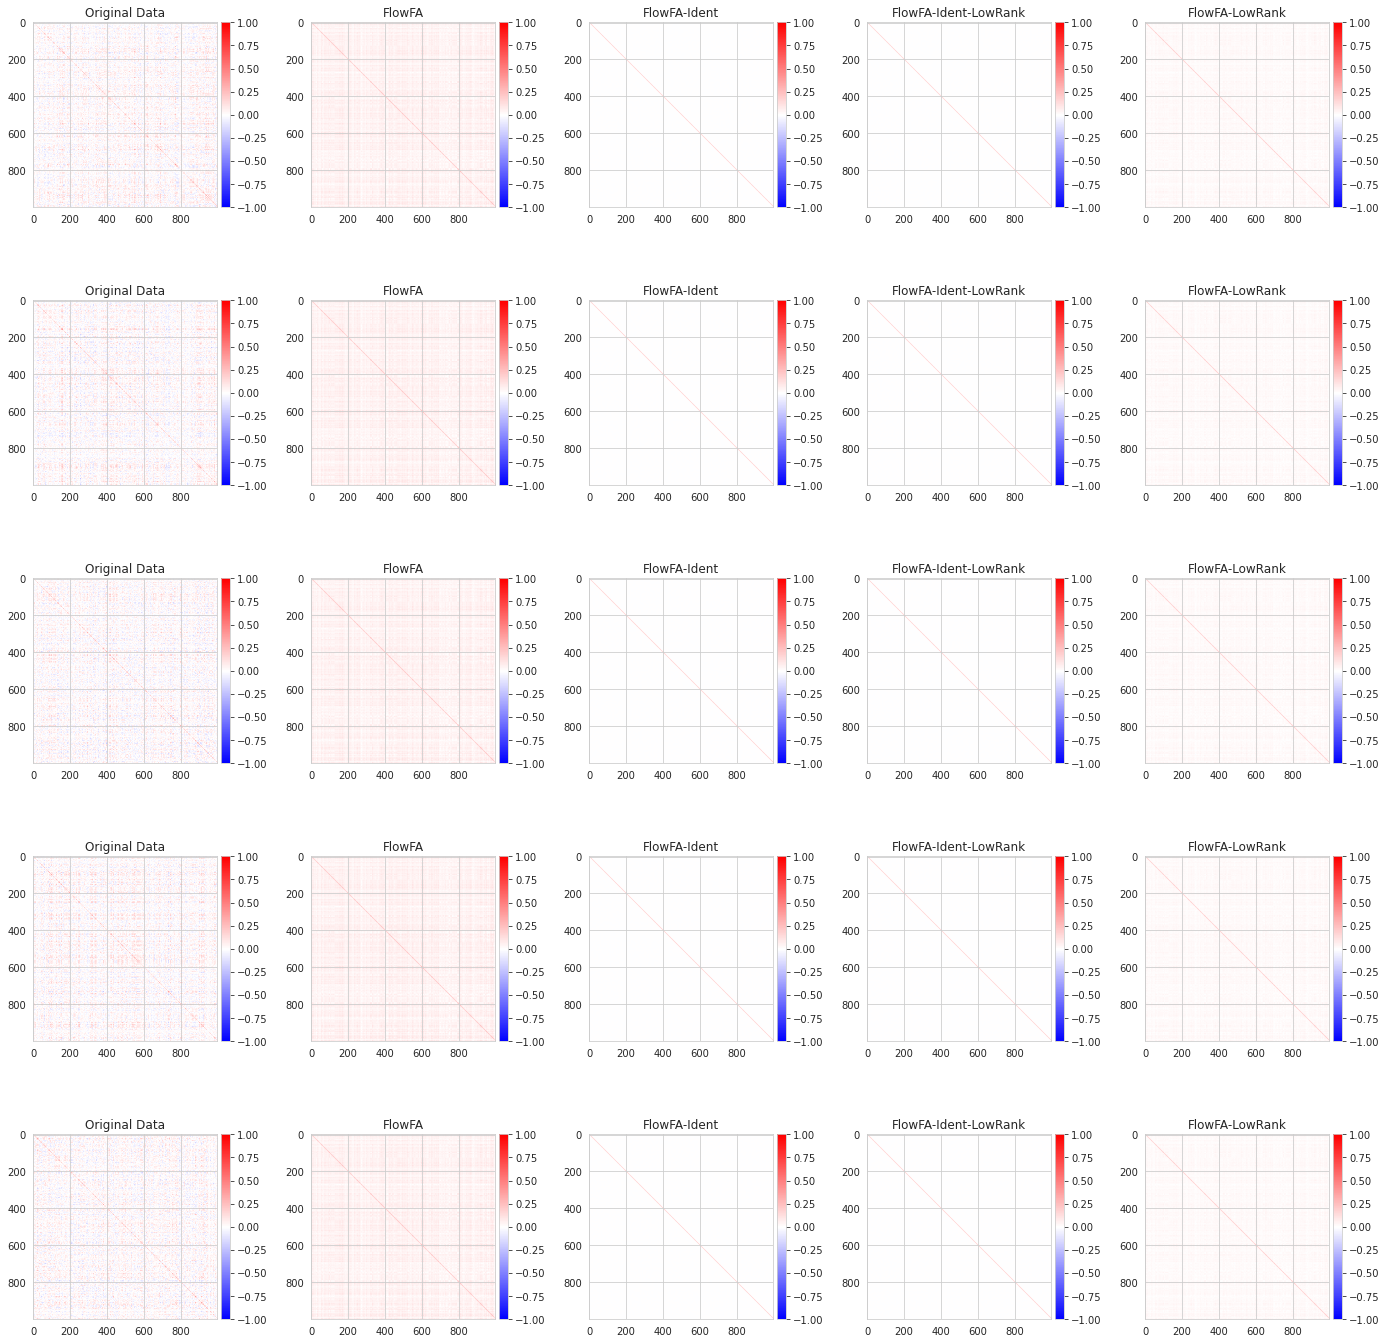

In [8]:
# save real and model correlation coeff (will be used later to calculate the difference)
original_values = []
model_values = [[[] for i in range(5)] for j in range(4)]

# create plot
fig, ax = plt.subplots(5,5, figsize=(20,20))
fig.tight_layout(pad=5.0)
for i in range(5):
    # get all repeated images
    img_indexes = indexes[inv == randoms[i]]

    # calculate real correlation coeff given the real data
    original_values.append(np.corrcoef(targets[img_indexes].T.detach().cpu()))

    # plot values and colorbar
    f = ax[i,0].imshow(original_values[-1], vmin=-1, vmax=1, cmap='bwr')
    divider = make_axes_locatable(ax[i,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(f, cax=cax, orientation='vertical')
    ax[i,0].set_title("Original Data")

# counter for other files than the models (needed for the indexing of the axis array)
p=0

# load each model, sample values, calculate correlation coeff
for i, file in enumerate((os.listdir("./models"))):
    if file == "results.txt" or file == ".ipynb_checkpoints" or file=="FlowFA-Original":
        p+=1
        continue
    model = torch.load(f"./models/{file}")
    mu = model.forward(*batch).cpu()

    for j in range(5):
        # get images
        img_indexes = indexes[inv == randoms[i-p]]
        # get gaussian latent
        normal = torch.distributions.multivariate_normal.MultivariateNormal(mu[img_indexes[0]], model.sigma.cpu())
        # sample
        samples = normal.sample([10000])
        # calculte correlation coeff
        model_values[i-p][j] = np.corrcoef(model.sample_transform(samples.to(device))[0].detach().cpu().T)

        # plot values and colorbar
        f = ax[j,i+1-p].imshow(model_values[i-p][j], vmin=-1, vmax=1, cmap='bwr')
        divider = make_axes_locatable(ax[j,i+1-p])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(f, cax=cax, orientation='vertical')
        ax[j, i+1-p].set_title(file)

plt.show()
fig.savefig("images/correlation.pdf", format="pdf", dpi=300)


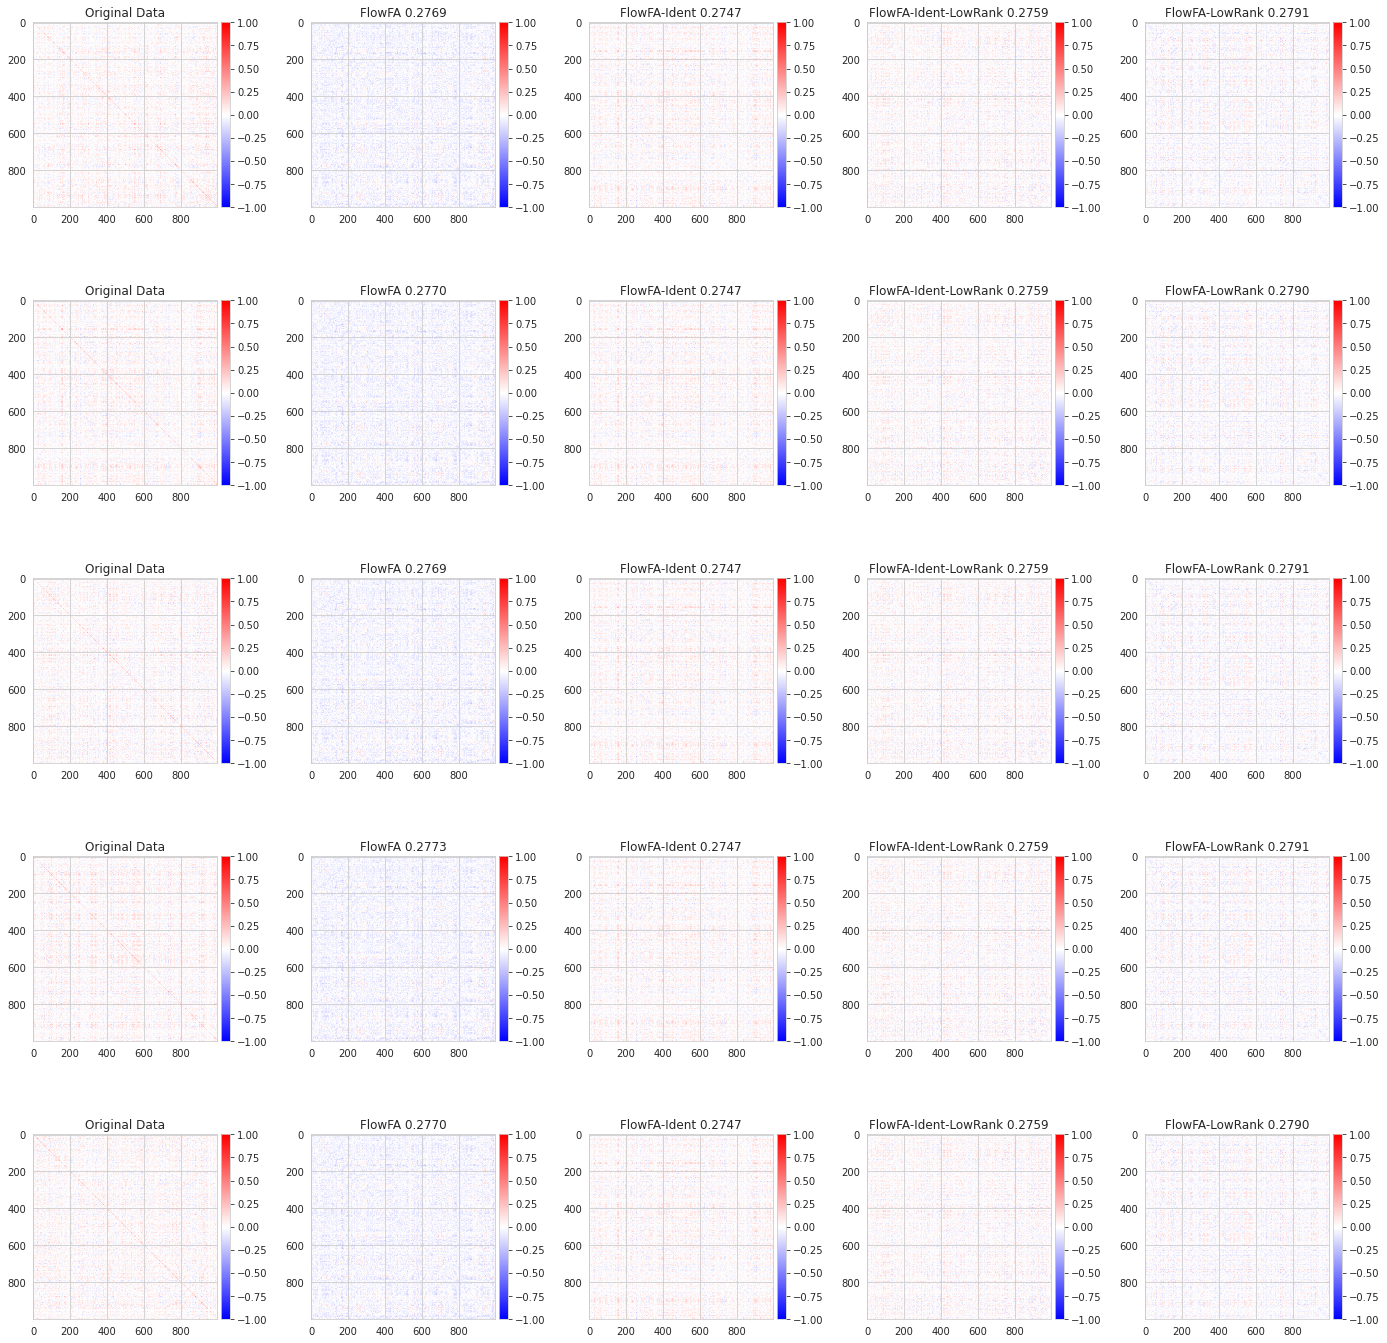

In [10]:
# same as before but we show the difference between real coeff value and model correlatin coeff
fig, ax = plt.subplots(5,5, figsize=(20,20))
fig.tight_layout(pad=5.0)
for i in range(5):
    img_indexes = indexes[inv == randoms[i]]
    f = ax[i,0].imshow(original_values[i], vmin=-1, vmax=1, cmap='bwr')
    divider = make_axes_locatable(ax[i,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(f, cax=cax, orientation='vertical')
    ax[i,0].set_title("Original Data")

p=0
for i, file in enumerate((os.listdir("./models"))):
    if file == "results.txt" or file == ".ipynb_checkpoints" or file == "FlowFA-Original":
        p+=1
        continue
    for j in range(5):
        # the difference is here
        dif=original_values[i-p]-model_values[i-p][j]
        f = ax[j,i+1-p].imshow(dif, vmin=-1, vmax=1, cmap='bwr')
        divider = make_axes_locatable(ax[j,i+1-p])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(f, cax=cax, orientation='vertical')
        ax[j, i+1-p].set_title(f"{file} {np.mean(np.abs(dif)):.4f}")
plt.show()
fig.savefig("images/correlation.dif.pdf", format="pdf", dpi=300)

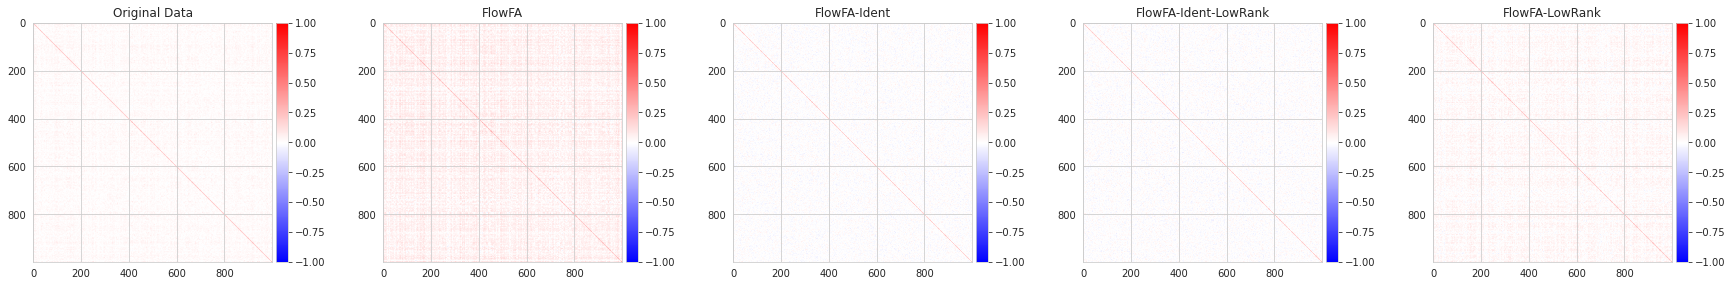

In [11]:
# calculate the correlation coeff over all images
fig, ax = plt.subplots(1,5, figsize=(25,5))
fig.tight_layout(pad=5.0)

# for real responses
f = ax[0].imshow(np.corrcoef(targets.T.detach().cpu()), vmax=1, vmin=-1, cmap="bwr")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(f, cax=cax, orientation='vertical')
ax[0].set_title("Original Data")

# for each model
p=0
for i, file in enumerate((os.listdir("./models"))):
    if file == "results.txt" or file == ".ipynb_checkpoints" or file == "FlowFA-Original":
        p+=1
        continue
    model = torch.load(f"./models/{file}")
    mu = model.forward(*batch).cpu()
    normal = torch.distributions.multivariate_normal.MultivariateNormal(mu, model.sigma.cpu())
    samples = normal.sample([100])
    f = ax[i+1-p].imshow(np.corrcoef(torch.mean(model.sample_transform(samples.to(device))[0].detach().cpu().T, dim=1)), vmin=-1, vmax=1, cmap='bwr')
    divider = make_axes_locatable(ax[i+1-p])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(f, cax=cax, orientation='vertical')
    ax[i+1-p].set_title(file)
plt.show()
fig.savefig("images/avg-correlation.pdf", format="pdf",dpi=300)